
Convallaria (*c. majalis*) acquired by Britta Schroth-Diez of the MPI-CBG Light Microscopy Facility,
denoised using structN2V. The data consists of 100 images of the same field of view, in order to
show structN2V denoising capabilities, we only select a single image as to not overestimate the
results by providing too much information to the network. The ground truth is obtained by averaging
all the images together.

In [11]:
# Imports necessary to execute the code
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pooch
import tifffile
from careamics import CAREamist
from careamics.config import create_n2v_configuration
from careamics.utils import autocorrelation
from PIL import Image

## Import the dataset

The dataset can be directly downloaded using the `careamics-portfolio` package, which
uses `pooch` to download the data.

In [12]:
# # instantiate data portfolio manage
# portfolio = PortfolioManager()

# # and download the data
# root_path = Path("./data")
# files = portfolio.denoising.Flower.download(root_path)

# create a folder for our data.
# TODO add it to the portfolio
path = Path("data")
if not path.exists():
    path.mkdir()

# download file
path_to_file = pooch.retrieve(
    "https://download.fht.org/jug/n2v/flower.tif",
    known_hash="08c2c77ae63d43d22631d69ae905ee695e8225cf9872183faf49bd0771e5b1a2",
    path=path,
)

## Visualize data and autocorrelation

Shape of the data (100, 1024, 1024)
Shape of the training data (1024, 1024)
Shape of the ground truth (1024, 1024)


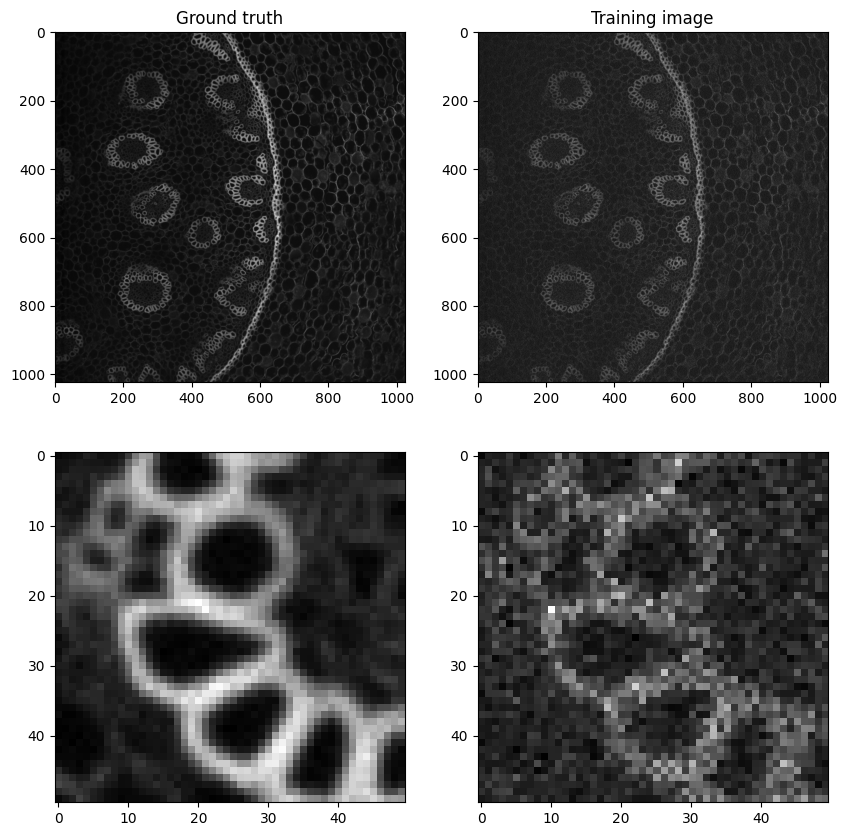

In [16]:
x_min, x_max = 580, 630
y_min, y_max = 380, 430

# load training and validation image and show them side by side
data = tifffile.imread(path_to_file)
print(f"Shape of the data {data.shape}")

train_image = data[50]
print(f"Shape of the training data {train_image.shape}")

gt_image = data.mean(axis=0)
print(f"Shape of the ground truth {gt_image.shape}")

# plot images
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(gt_image, cmap="gray")
ax[0, 0].set_title("Ground truth")

ax[0, 1].imshow(train_image, cmap="gray")
ax[0, 1].set_title("Training image")

ax[1, 0].imshow(gt_image[x_min:x_max, y_min:y_max], cmap="gray")

ax[1, 1].imshow(train_image[x_min:x_max, y_min:y_max], cmap="gray")

### Visualize autocorrelation

The autocorrelation shows a slight horizontal correlation.

Text(0.5, 1.0, 'Autocorrelation')

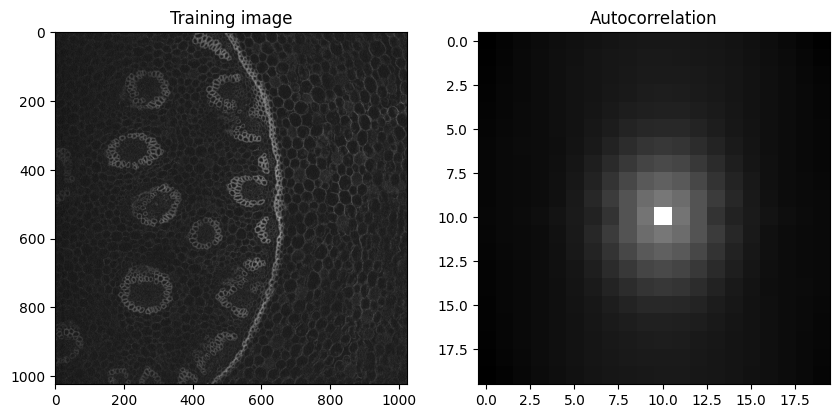

In [20]:
# compute autocorrelation
autocorr = autocorrelation(train_image)

# crop the correlation around (0, 0)
midpoint = train_image.shape[0] // 2
crop_size = 10
slices = (
    slice(midpoint - crop_size, midpoint + crop_size),
    slice(midpoint - crop_size, midpoint + crop_size),
)

# plot image and autocorrelation
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(train_image, cmap="gray")
ax[0].set_title("Training image")

ax[1].imshow(autocorr[slices], cmap="gray")
ax[1].set_title("Autocorrelation")

## Train with CAREamics

The easiest way to use CAREamics is to create a configuration and a `CAREamist`. 

### Create configuration

The configuration can be built from scratch, giving the user full control over the various
parameters available in CAREamics. However, a straightforward way to create a configuration
for a particular algorithm is to use one of the convenience functions.

To use structN2V, we simply add the relevant parameters to the configuration.

In [22]:
config = create_n2v_configuration(
    experiment_name="convallaria_structn2v",
    data_type="array",
    axes="YX",
    patch_size=(64, 64),
    batch_size=16,
    num_epochs=30,
    struct_n2v_axis="horizontal",
    struct_n2v_span=9,
)

print(config)

{'algorithm_config': {'algorithm': 'n2v',
                      'loss': 'n2v',
                      'lr_scheduler': {'name': 'ReduceLROnPlateau',
                                       'parameters': {}},
                      'model': {'architecture': 'UNet',
                                'conv_dims': 2,
                                'depth': 2,
                                'final_activation': 'None',
                                'in_channels': 1,
                                'independent_channels': True,
                                'n2v2': False,
                                'num_channels_init': 32,
                                'num_classes': 1},
                      'optimizer': {'name': 'Adam',
                                    'parameters': {'lr': 0.0001}}},
 'data_config': {'axes': 'YX',
                 'batch_size': 1,
                 'data_type': 'array',
                 'patch_size': [64, 64],
                 'transforms': [{'flip_x': True,
      

### Train

A `CAREamist` can be created using a configuration alone, and then be trained by using
the data already loaded in memory.

In [23]:
# instantiate a CAREamist
careamist = CAREamist(source=config)

# train
careamist.train(
    train_source=train_image,
)

No working directory provided. Using current working directory: /Users/joran.deschamps/git/careamics/careamics-examples/applications/n2v/2D.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/joran.deschamps/miniconda3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Missing logger folder: /Users/joran.deschamps/git/careamics/careamics-examples/applications/n2v/2D/lightning_logs
Computed dataset mean: [548.40212345

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/joran.deschamps/miniconda3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/joran.deschamps/miniconda3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 230/230 [00:08<00:00, 25.67it/s, train_loss_step=0.301, val_loss=0.735, train_loss_epoch=0.856]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 230/230 [00:09<00:00, 25.53it/s, train_loss_step=0.301, val_loss=0.735, train_loss_epoch=0.856]


## Predict with CAREamics

Prediction is done with the same `CAREamist` used for training. Because the image is large
we predict using tiling.

In [24]:
prediction = careamist.predict(source=train_image, tile_size=(256, 256))

/Users/joran.deschamps/miniconda3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

### Visualize the prediction

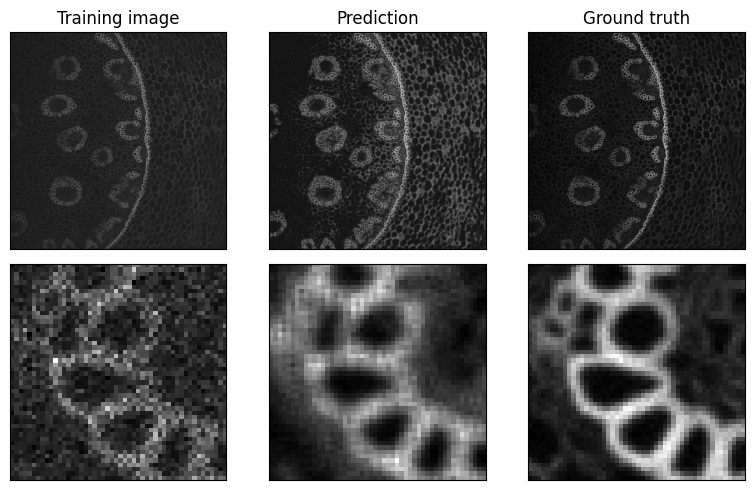

In [35]:
x_min, x_max = 580, 630
y_min, y_max = 380, 430

# plot images
fig, ax = plt.subplots(2, 3, figsize=(8, 5))
ax[0, 0].imshow(train_image, cmap="gray")
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])
ax[0, 0].set_title("Training image")

ax[0, 1].imshow(prediction[0].squeeze(), cmap="gray")
ax[0, 1].set_title("Prediction")
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

ax[0, 2].imshow(gt_image, cmap="gray")
ax[0, 2].set_title("Ground truth")
ax[0, 2].set_xticks([])
ax[0, 2].set_yticks([])

ax[1, 0].imshow(train_image[x_min:x_max, y_min:y_max], cmap="gray")
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

ax[1, 1].imshow(prediction[0].squeeze()[x_min:x_max, y_min:y_max], cmap="gray")
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])

ax[1, 2].imshow(gt_image[x_min:x_max, y_min:y_max], cmap="gray")
ax[1, 2].set_xticks([])
ax[1, 2].set_yticks([])

fig.tight_layout()
plt.show()

## Export the model

The model is automatically saved during training (the so-called `checkpoints`) and can 
be loaded back easily, but you can also export the model to the [BioImage Model Zoo](www.bioimage.io)
format.

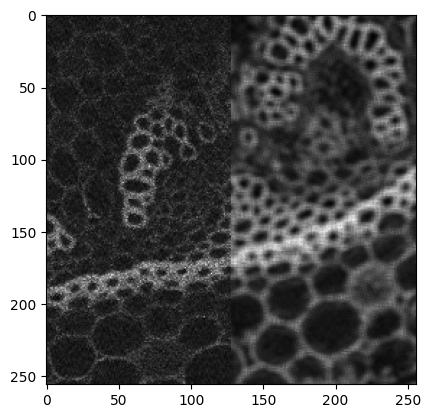

In [39]:
# create a cover image
x_start, width = 650, 256
y_start, height = 450, 256

# rotate images
rot_train = np.rot90(train_image, 3)
rot_pred = np.rot90(prediction[0].squeeze(), 3)

# create image
cover = np.zeros((height, width))

# normalize train and prediction
norm_train = (rot_train - rot_train.min()) / (rot_train.max() - rot_train.min())
norm_pred = (rot_pred - rot_pred.min()) / (rot_pred.max() - rot_pred.min())

# fill in halves
cover[:, : width // 2] = norm_train[
    y_start : y_start + height, x_start : x_start + width // 2
]
cover[:, width // 2 :] = norm_pred[
    y_start : y_start + height, x_start + width // 2 : x_start + width
]

# plot the single image
plt.imshow(cover, cmap="gray")

# save the image
im = Image.fromarray(cover * 255)
im = im.convert("L")
im.save("Convallaria_structN2V.jpeg")